# ANALYSIS OF NIGERIA'S COVID-19 DATA

## Data Collection

### A - NCDC website scrap
Get relevant COVID-19 data from the NCDC website - https://covid19.ncdc.gov.ng

In [1]:
# Import libraries
import os
import glob
import requests
import numpy as np
import pandas as pd
import datetime as dt
import csv
from bs4 import BeautifulSoup
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')  
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Request the NCDC page containing the required info
page = requests.get('https://covid19.ncdc.gov.ng')

# Parse `page` content with `BeautifulSoup`
soup = BeautifulSoup(page.content, 'html.parser')

#### Extract summary info about samples tested and COVID-19 cases.
* Save the info as a pandas Series 

In [3]:
# After inspecting the source of the `page` object and the contents of the `soup` object:
covid_summary = {}

for title, stat in zip(soup.select('h6.text-white'), soup.select('h2 > span')):
    covid_summary[title.text] = stat.text.replace(',', '')
    
covid_summary_S = pd.Series(covid_summary, name='COVID')

# Convert from object to integer data type
covid_summary_S = pd.to_numeric(covid_summary_S)
covid_summary_S

Samples Tested      2266591
Confirmed Cases      167375
Active Cases           1340
Discharged Cases     163917
Death                  2118
Name: COVID, dtype: int64

#### Extract data from the `Confirmed Cases by States` table on the NCDC website

In [4]:
# Create a list containing the column names of the table
header_list = []

for th in soup.select('th'):
    header_list.append(th.text)
    
header_list

['States Affected',
 'No. of Cases (Lab Confirmed)',
 'No. of Cases (on admission)',
 'No. Discharged',
 'No. of Deaths']

In [5]:
# Extract table data
table_data = soup.select('tr')[1:] # row[0] contains info about column name
data_list = []

for tr in table_data:
    state = tr.select('td')[0].text.strip()
    cases_c = tr.select('td')[1].text.strip()
    cases_a = tr.select('td')[2].text.strip()
    discharged = tr.select('td')[3].text.strip()
    deaths = tr.select('td')[4].text.strip()
    data_list.append([state, cases_c, cases_a, discharged, deaths])
    
# Save the data in `data_list` to a DataFrame.
covid_data_states = pd.DataFrame(data_list, columns=header_list)

In [6]:
# Set the current working directory and export `covid_data_states` as csv
os.chdir("/Users/osala/Downloads/Nigeria-COVID-19-Data-Analysis-Using-Python-main")

covid_data_states.to_csv("COVID-19 data by state.csv", index=False)

### B - John Hopkins Data Repository 
* Global Daily Confirmed Cases - Click [Here](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)
* Global Daily Recovered Cases - Click [Here](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv)
* Global Daily Death Cases - Click [Here](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv)

#### Save COVID-19 data from the GitHub repo links above to a DataFrame and also export as csv.

In [7]:
confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_dly_gbl = pd.read_csv(confirmed_url)
confirmed_dly_gbl.to_csv("time_series_covid19_confirmed_global", index=False)

recovered_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recovered_dly_gbl = pd.read_csv(recovered_url)
recovered_dly_gbl.to_csv("time_series_covid19_recovered_global", index=False)

deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths_dly_gbl = pd.read_csv(deaths_url)
deaths_dly_gbl.to_csv("time_series_covid19_deaths_global", index=False)

### C - External Data 
1. `covid_external.csv`: This contains data about Nigeria's Community Vulnerability Index. [Data dictionary](https://docs.google.com/document/d/1BqQvTH-dV1xD5QWoMHlcY0PQC39RZ7-0hjqccozaG9k/edit). [Resource link](https://covid-static-assets.s3.amazonaws.com/Africa+CCVI+methodology.pdf).
2. `Budget data.csv`: Info about initial and revised budgets per state
3. `RealGDP.csv`: Nigeria's GDP data from 2014 to 2020

In [8]:
covid_ext = pd.read_csv('covid_external.csv')
budget = pd.read_csv('Budget data.csv')
gdp = pd.read_csv('RealGDP.csv')

## View the data
Obtain basic information about all the collected data using the `head()` and `info()` methods.

In [9]:
data = ['covid_data_states', 'confirmed_dly_gbl', 'recovered_dly_gbl', 'deaths_dly_gbl',
        'covid_ext', 'budget', 'gdp']

for dataf in data:
    print(dataf.upper())
    print(eval(f'{dataf}.head()'), '\n')
    print(eval(f'{dataf}.info()'), '\n\n\n')

COVID_DATA_STATES
  States Affected No. of Cases (Lab Confirmed) No. of Cases (on admission)  \
0           Lagos                       59,457                         486   
1             FCT                       19,884                         513   
2          Kaduna                        9,108                           8   
3         Plateau                        9,065                           2   
4          Rivers                        7,313                          39   

  No. Discharged No. of Deaths  
0         58,515           456  
1         19,205           166  
2          9,035            65  
3          9,006            57  
4          7,173           101   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   States Affected               37 non-null     object
 1   No. of Cases (Lab Confirmed)  37

## Data Cleaning and Preparation 
* Rename the columns of the scraped data.
* Remove commas (,) in the numerical data.
* Convert to the appropriate data type.
* Extract data for Nigeria from the global daily cases data.

#### A - Clean the scraped data

In [10]:
# Rename some columns in `covid_data_states`
covid_data_states.rename(columns={'No. of Cases (Lab Confirmed)': 'Lab Confirmed Cases',
                                  'No. of Cases (on admission)': 'Cases on Admission',
                                  'No. Discharged': 'Discharged', 'No. of Deaths': 'Deaths'}, inplace=True)

# Remove commas from numeric data and convert to the int datatype
covid_data_states.replace({',': ''}, regex=True, inplace=True)

for column in covid_data_states.iloc[:,1:]:
    covid_data_states[column] = pd.to_numeric(covid_data_states[column])

covid_data_states.info()
covid_data_states.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   States Affected      37 non-null     object
 1   Lab Confirmed Cases  37 non-null     int64 
 2   Cases on Admission   37 non-null     int64 
 3   Discharged           37 non-null     int64 
 4   Deaths               37 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.6+ KB


,States Affected,Lab Confirmed Cases,Cases on Admission,Discharged,Deaths
0,Lagos,59457,486,58515,456
1,FCT,19884,513,19205,166
2,Kaduna,9108,8,9035,65
3,Plateau,9065,2,9006,57
4,Rivers,7313,39,7173,101
5,Oyo,6858,0,6734,124
6,Edo,4910,0,4725,185
7,Ogun,4683,0,4633,50
8,Kano,4000,12,3878,110
9,Ondo,3469,36,3368,65


* There are no missing data

#### B - Get a Pandas DataFrame for Daily Confirmed Cases in Nigeria. Column names are `Date` and `No of Cases`

In [11]:
# Create a filter to select only cases in Nigeria
bool_c = confirmed_dly_gbl['Country/Region'] == 'Nigeria'
confirmed_dly_nig = confirmed_dly_gbl.loc[bool_c]   # Filter applied
cases_c = int(confirmed_dly_nig.index.values)       # Index of the Boolean slice: useful when renaming below

# Transpose the data, select rows containing only dates and cases, reset the index, then rename the columns
confirmed_dly_nig = confirmed_dly_nig.transpose().iloc[4:, :].reset_index().rename(
                    columns={'index': 'Date', cases_c: 'No of Cases'})

# Convert the columns to the appropriate datetime and numeric datatypes
confirmed_dly_nig['Date'] = pd.to_datetime(confirmed_dly_nig['Date'])
confirmed_dly_nig['No of Cases'] = pd.to_numeric(confirmed_dly_nig['No of Cases'])

'''
# Alternatively:
# Select columns containing only dates and cases
confirmed_dly_nig = confirmed_dly_nig.iloc[:, 4:]

# Create a list of lists containing dates and corresponding values for each date
confirmed_dly_nigeria_list = [[date, case] for date, case in zip(confirmed_dly_nigeria.columns.tolist(),
                                                                 confirmed_dly_nigeria.values[0].tolist())]

# Create a new dataframe from the list above
confirmed_dly_nigeria = pd.DataFrame(confirmed_dly_nigeria_list, columns=['Date', 'No of Cases'])
'''
confirmed_dly_nig.info()
confirmed_dly_nig

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         519 non-null    datetime64[ns]
 1   No of Cases  519 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.2 KB


,Date,No of Cases
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
514,2021-06-19,167206
515,2021-06-20,167206
516,2021-06-21,167292
517,2021-06-22,167331


#### C - Get a Pandas DataFrame for Daily Recovered Cases in Nigeria. Columns are `Date` and `No of Cases`

In [12]:
# Similar process as in B above
bool_r = recovered_dly_gbl['Country/Region'] == 'Nigeria'
recovered_dly_nig = recovered_dly_gbl.loc[bool_r]
cases_r = int(recovered_dly_nig.index.values)

recovered_dly_nig = recovered_dly_nig.transpose().iloc[4:, :].reset_index().rename(
                    columns={'index': 'Date', cases_r: 'No of Cases'})

recovered_dly_nig['Date'] = pd.to_datetime(recovered_dly_nig['Date'])
recovered_dly_nig['No of Cases'] = pd.to_numeric(recovered_dly_nig['No of Cases'])
recovered_dly_nig

,Date,No of Cases
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
514,2021-06-19,163550
515,2021-06-20,163557
516,2021-06-21,163797
517,2021-06-22,163913


#### D - Get a Pandas DataFrame for Daily Death Cases in Nigeria. Columns are `Date` and `No of Cases`

In [13]:
#Similar process as in B above
bool_d = deaths_dly_gbl['Country/Region'] == 'Nigeria'
deaths_dly_nig = deaths_dly_gbl.loc[bool_d]
cases_d = int(deaths_dly_nig.index.values)

deaths_dly_nig = deaths_dly_nig.transpose().iloc[4:, :].reset_index().rename(
                    columns={'index': 'Date', cases_d: 'No of Cases'})

deaths_dly_nig['Date'] = pd.to_datetime(deaths_dly_nig['Date'])
deaths_dly_nig['No of Cases'] = pd.to_numeric(deaths_dly_nig['No of Cases'])

deaths_dly_nig

,Date,No of Cases
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
514,2021-06-19,2117
515,2021-06-20,2117
516,2021-06-21,2118
517,2021-06-22,2118


## Analysis
Here I will perform analysis on the data sets.

#### Summary of Nigeria's COVID-19 statistics

Text(0.5, 1.0, 'SAMPLES TESTED FOR COVID-19 AND OUTCOMES')

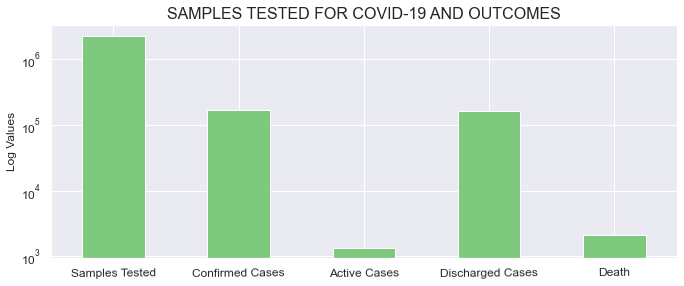

In [14]:
dark_grid_style = sns.set_theme(style="darkgrid")

covid_summary_S.plot(kind='bar', figsize=(10,4), colormap='Accent', fontsize=12, logy=True, ylabel='Log Values',
                     rot=0.5)
plt.title('SAMPLES TESTED FOR COVID-19 AND OUTCOMES', fontsize=16)

* A small proportion of samples tested returned positive for COVID-19.
* Most of the confirmed cases were discharged with a tiny percentage resulting in death.

#### A - Generate a plot showing the top 10 states in terms of lab-confirmed COVID-19 cases

Text(0.5, 1.0, 'TOP 10 STATES WITH CONFIRMED CASES')

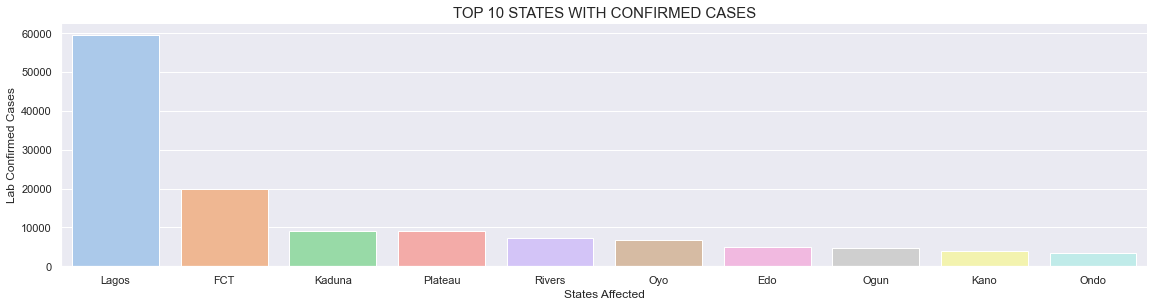

In [15]:
sns.catplot(x="States Affected", y="Lab Confirmed Cases", kind='bar', aspect=4, height=4, palette='pastel',
            data=covid_data_states.nlargest(10, 'Lab Confirmed Cases'))
plt.title('TOP 10 STATES WITH CONFIRMED CASES', fontsize=15)

* Lagos has, by a large margin (more than twice), the highest number of confirmed cases; then FCT and Kaduna.

#### B - Generate a plot that shows the top 10 states in terms of discharged COVID cases.

Text(0.5, 1.0, 'TOP 10 STATES WITH DISCHARGED CASES')

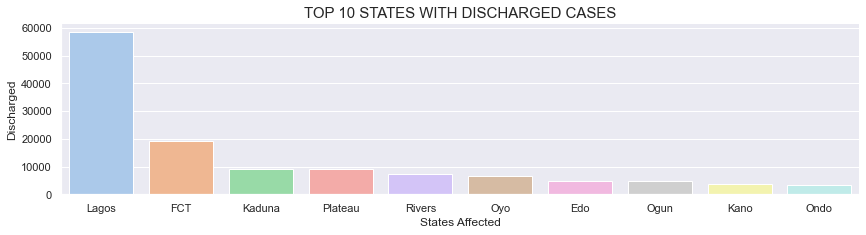

In [16]:
sns.catplot(x="States Affected", y="Discharged", kind='bar', aspect=4, height=3, palette='pastel',
                  data=covid_data_states.nlargest(10, 'Discharged'))
plt.title('TOP 10 STATES WITH DISCHARGED CASES', fontsize=15)

* The same pattern as above is also seen here with Lagos having the highest number of discharged cases

#### C - Plot the top 10 states with the highest death cases

Text(0.5, 1.0, 'TOP 10 STATES BY DEATHS')

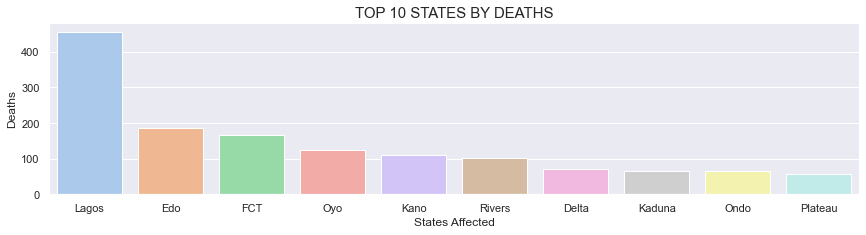

In [17]:
sns.catplot(x="States Affected", y="Deaths", kind='bar', aspect=4, height=3, palette='pastel',
                  data=covid_data_states.nlargest(10, 'Deaths'))
plt.title('TOP 10 STATES BY DEATHS', fontsize=15)            

* There's a change here. Lagos has the highest number of deaths from COVID-19, followed by Edo then FCT.

#### D - Generate a line plot for the total daily confirmed, recovered and death cases in Nigeria

Text(0.5, 1.0, 'CUMULATIVE DEATHS')

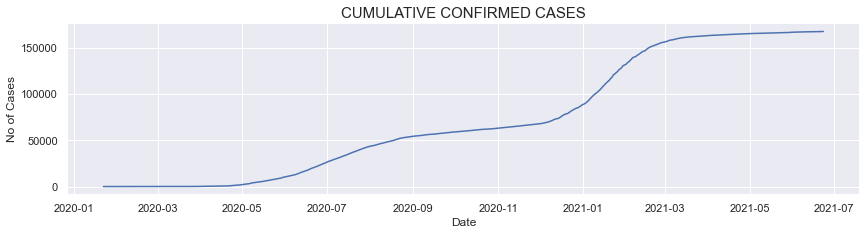

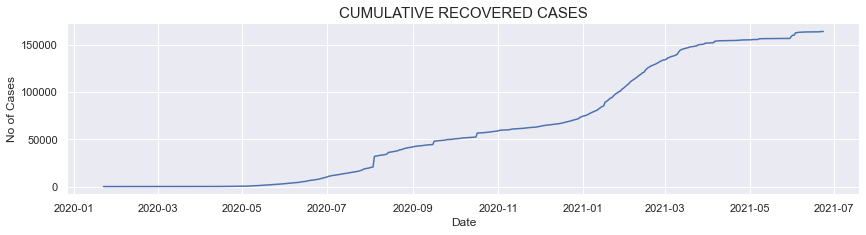

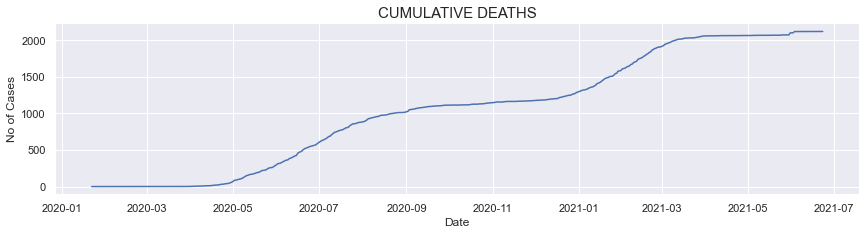

In [18]:
sns.relplot(data=confirmed_dly_nig, kind="line", x="Date", y="No of Cases", aspect=4, height=3, palette='pastel')
plt.title('CUMULATIVE CONFIRMED CASES', fontsize=15) 

sns.relplot(data=recovered_dly_nig, kind="line", x="Date", y="No of Cases", aspect=4, height=3, palette='pastel')
plt.title('CUMULATIVE RECOVERED CASES', fontsize=15)

sns.relplot(data=deaths_dly_nig, kind="line", x="Date", y="No of Cases", aspect=4, height=3, palette='pastel')
plt.title('CUMULATIVE DEATHS', fontsize=15)

* All three line plots show a two-phased logarithmic growth pattern.
* The first increase in cases and deaths occured around 5-6 months after the onset of the pandemic while the second increase occured early this year.

#### E - Determine the daily infection rate.
* Generate a line plot for the above.
* Do the same for the daily recovered and death rates

In [19]:
# Use the `.diff` method to derive no of cases per day
confirmed_dly_nig['Daily Cases'] = confirmed_dly_nig['No of Cases'].diff()
confirmed_dly_nig

,Date,No of Cases,Daily Cases
0,2020-01-22,0,NaN
1,2020-01-23,0,0.0
2,2020-01-24,0,0.0
3,2020-01-25,0,0.0
4,2020-01-26,0,0.0
...,...,...,...
514,2021-06-19,167206,51.0
515,2021-06-20,167206,0.0
516,2021-06-21,167292,86.0
517,2021-06-22,167331,39.0


Text(0.5, 1.0, 'DAILY CONFIRMED CASES')

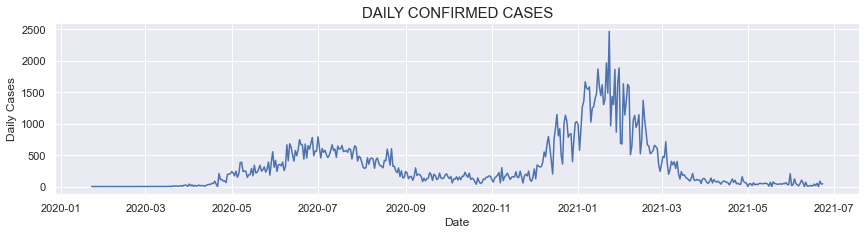

In [20]:
sns.relplot(
    data=confirmed_dly_nig, kind="line",
    x="Date", y="Daily Cases", aspect=4, height=3, palette='pastel')
plt.title('DAILY CONFIRMED CASES', fontsize=15)

* There was an increase in daily confirmed cases around the middle of 2020 and a higher (up to 4-fold) increase earlier this year.

Text(0.5, 1.0, 'DAILY RECOVERIES')

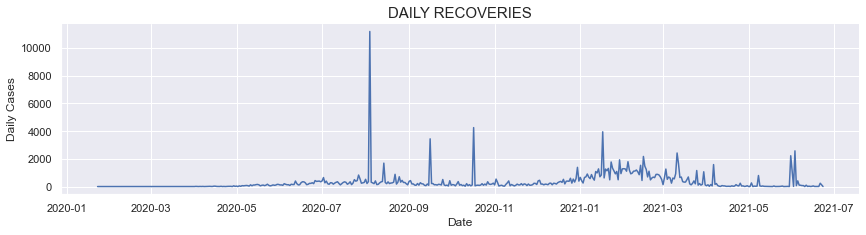

In [21]:
recovered_dly_nig['Daily Cases'] = recovered_dly_nig['No of Cases'].diff()

sns.relplot(
    data=recovered_dly_nig, kind="line",
    x="Date", y="Daily Cases", aspect=4, height=3, palette='pastel')
plt.title('DAILY RECOVERIES', fontsize=15)

* Sharp spikes in the no of daily recoveries are seen at several intervals in the time series.
* The sharpest spike is seen around the 8th month of 2020.
* A relatively sustained increase in recovery cases is seen early this year.

Text(0.5, 1.0, 'DAILY DEATH RATES')

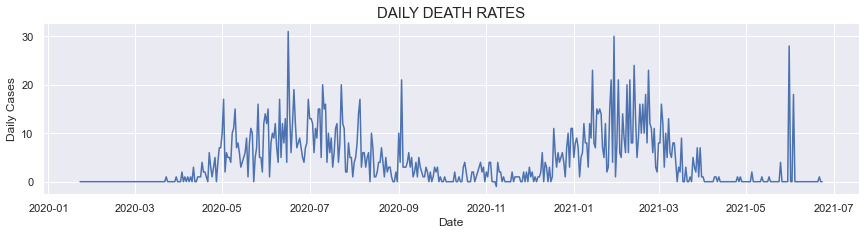

In [22]:
deaths_dly_nig['Daily Cases'] = deaths_dly_nig['No of Cases'].diff()

sns.relplot(
    data=deaths_dly_nig, kind="line",
    x="Date", y="Daily Cases", aspect=4, height=3, palette='pastel')
plt.title('DAILY DEATH RATES', fontsize=15)

* The daily death rates also follow the general pattern of a two-phased increase in the number of confirmed cases and recoveries with a more jagged outline.
* The jagged outlines suggest that reports may not have arrived daily as cases might have accumulated over weekends and then reported on the first day of the week.

#### F - Calculate maximum infection rate in a day (number of new cases); the maximum no of recoveries in a day, and the maximum daily death rate
* Find the corresponding dates

In [23]:
confirmed_dly_nig.iloc[confirmed_dly_nig['Daily Cases'].idxmax(), [0, 2]]

Date           2021-01-23 00:00:00
Daily Cases                   2464
Name: 367, dtype: object

**The maximum daily infection rate is 2,464 on the 23rd of January, 2021**

In [24]:
recovered_dly_nig.iloc[recovered_dly_nig['Daily Cases'].idxmax(), [0, 2]]

Date           2020-08-04 00:00:00
Daily Cases                  11188
Name: 195, dtype: object

**The maximum no of daily recoveries is 11,188 on the 4th of August, 2020**

In [25]:
deaths_dly_nig.iloc[deaths_dly_nig['Daily Cases'].idxmax(), [0, 2]]

Date           2020-06-16 00:00:00
Daily Cases                     31
Name: 146, dtype: object

**The maximum daily death rate, 31, occurred on the 16th of June, 2020**

#### G - Determine any relationship between the `covid_ext` and the NCDC COVID-19 dataset. 
* Combine both data sets on a common column `States`.
* Generate a line plot with the top 10 confirmed cases and the overall COVID-19 community vulnerability index (`Overall CCVI Index`) on the same axis.

In [26]:
# Correct spelling errors within the 'states' column of covid_ext.
covid_ext.iloc[[3,30], 0] = ['Nasarawa', 'Cross River']

# Rename the `States Affected` and `states` columns to `States` in both dataframes
covid_data_states.rename(columns={'States Affected': 'States'}, inplace=True)
covid_ext.rename(columns={'states': 'States'}, inplace=True)

# Merge both dataframes using `pd.merge()`
covid_states_ext = pd.merge(covid_data_states, covid_ext, how='outer', on='States')

covid_states_ext.info()
covid_states_ext.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   States                   37 non-null     object 
 1   Lab Confirmed Cases      37 non-null     int64  
 2   Cases on Admission       37 non-null     int64  
 3   Discharged               37 non-null     int64  
 4   Deaths                   37 non-null     int64  
 5   region                   37 non-null     object 
 6   Population               37 non-null     int64  
 7   Overall CCVI Index       37 non-null     float64
 8   Age                      37 non-null     float64
 9   Epidemiological          37 non-null     float64
 10  Fragility                37 non-null     float64
 11  Health System            37 non-null     float64
 12  Population Density       37 non-null     float64
 13  Socio-Economic           37 non-null     float64
 14   Transport Availability  37 

,States,Lab Confirmed Cases,Cases on Admission,Discharged,Deaths,region,Population,Overall CCVI Index,Age,Epidemiological,Fragility,Health System,Population Density,Socio-Economic,Transport Availability,Acute IHR
0,Lagos,59457,486,58515,456,South West,13992000,0.0,0.1,1.0,0.3,0.1,1.0,0.1,0.4,0.93
1,FCT,19884,513,19205,166,North Central,4865000,0.3,0.0,0.9,0.4,0.6,0.9,0.6,0.2,0.79
2,Kaduna,9108,8,9035,65,North West,9227000,0.7,0.1,0.9,0.8,0.9,0.4,0.6,0.4,0.86
3,Plateau,9065,2,9006,57,North Central,4766000,0.4,0.5,0.4,0.8,0.3,0.3,0.5,0.3,0.93
4,Rivers,7313,39,7173,101,South South,7763000,0.4,0.5,0.9,0.6,0.6,0.9,0.1,0.1,1.00
5,Oyo,6858,0,6734,124,South West,8737000,0.2,0.7,0.8,0.2,0.8,0.6,0.2,0.3,1.06
6,Edo,4910,0,4725,185,South South,4705000,0.1,0.9,0.8,0.1,0.1,0.5,0.4,0.3,1.09
7,Ogun,4683,0,4633,50,South West,5878000,0.3,0.6,0.7,0.5,0.6,0.6,0.0,0.2,1.07
8,Kano,4000,12,3878,110,North West,14726000,0.6,0.2,0.1,0.3,0.4,0.8,0.8,0.5,0.87
9,Ondo,3469,36,3368,65,South West,5185000,0.1,0.8,0.5,0.1,0.3,0.6,0.3,0.3,1.04


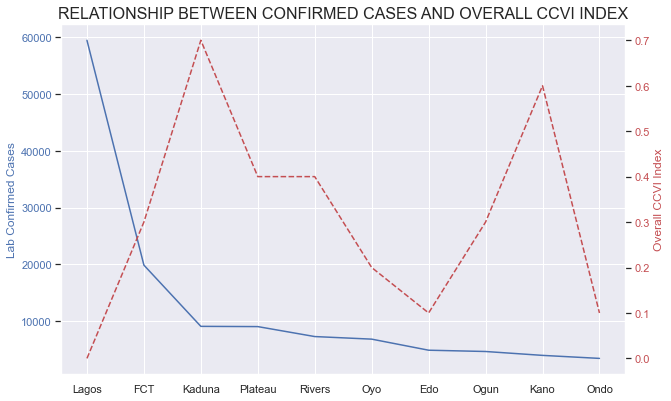

In [27]:
fig = plt.figure(figsize = (9,6))
plt.title('RELATIONSHIP BETWEEN CONFIRMED CASES AND OVERALL CCVI INDEX', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.plot('States', 'Lab Confirmed Cases', 'b-', data=covid_states_ext.nlargest(10, 'Lab Confirmed Cases'))
ax1.set_ylabel('Lab Confirmed Cases', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot('States', 'Overall CCVI Index', 'r--', data=covid_states_ext.nlargest(10, 'Lab Confirmed Cases'))
ax2.set_ylabel('Overall CCVI Index', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
plt.grid(b=None)

* Lagos has the highest number of cases and correspondingly the lowest overall CCVI index

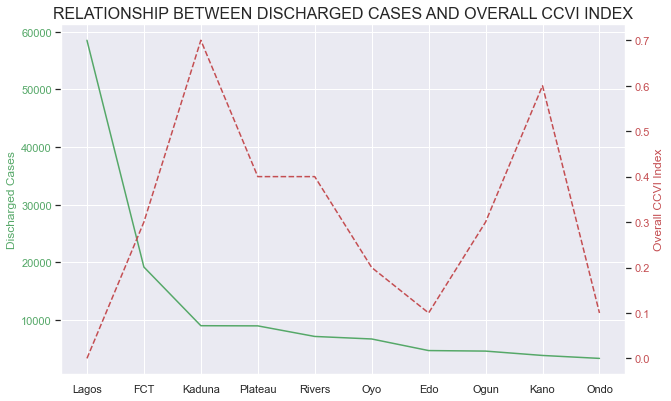

In [28]:
fig = plt.figure(figsize = (9,6))
plt.title('RELATIONSHIP BETWEEN DISCHARGED CASES AND OVERALL CCVI INDEX', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.plot('States', 'Discharged', 'g-', data=covid_states_ext.nlargest(10, 'Discharged'))
ax1.set_ylabel('Discharged Cases', color='g')
for tl in ax1.get_yticklabels():
    tl.set_color('g')

ax2 = ax1.twinx()
ax2.plot('States', 'Overall CCVI Index', 'r--', data=covid_states_ext.nlargest(10, 'Discharged'))
ax2.set_ylabel('Overall CCVI Index', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
plt.grid(b=None)    

* Lagos also has the highest number of discharged cases despite its low overall CCVI index

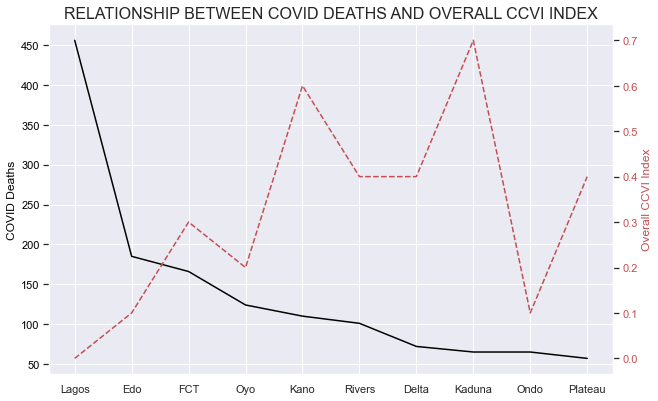

In [29]:
fig = plt.figure(figsize = (9,6))
plt.title('RELATIONSHIP BETWEEN COVID DEATHS AND OVERALL CCVI INDEX', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.plot('States', 'Deaths', 'black', data=covid_states_ext.nlargest(10, 'Deaths'))
ax1.set_ylabel('COVID Deaths', color='black')
for tl in ax1.get_yticklabels():
    tl.set_color('black')

ax2 = ax1.twinx()
ax2.plot('States', 'Overall CCVI Index', 'r--', data=covid_states_ext.nlargest(10, 'Deaths'))
ax2.set_ylabel('Overall CCVI Index', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
plt.grid(b=None)    

* There's a clearer relationship between the overall CCVI index and deaths. States with a low overall CCVI index tend to have a higher number of COVID-19 deaths with exceptions.
* A notable exception is Ondo State.

#### H - Determine the relationship between the `covid_ext` and the NCDC COVID-19 dataset. 
* Generate a regression plot between two variables to visualize the linear relationships - `Lab Confirmed Cases` and `Population Density`.

Text(0.5, 1.0, 'POPULATION DENSITY VS CONFIRMED CASES')

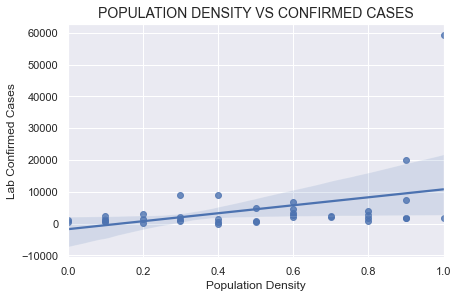

In [30]:
sns.regplot(y='Lab Confirmed Cases', x='Population Density',
            data=covid_states_ext)
plt.title('POPULATION DENSITY VS CONFIRMED CASES', fontsize=14)

* Population density is not a reliable predictor of confirmed cases

Text(0.5, 1.0, 'POPULATION DENSITY VS DISCHARGED CASES')

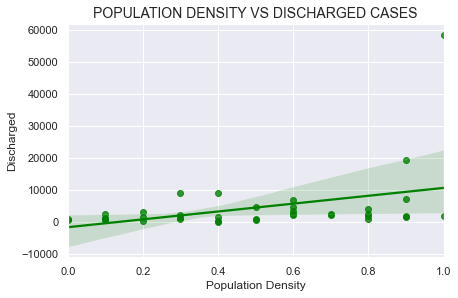

In [31]:
sns.regplot(y='Discharged', x='Population Density',
            data=covid_states_ext, color='green')
plt.title('POPULATION DENSITY VS DISCHARGED CASES', fontsize=14)

* Population density is a poor predictor of discharged cases

Text(0.5, 1.0, 'POPULATION DENSITY VS DEATHS')

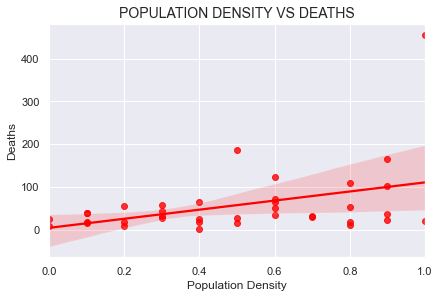

In [32]:
sns.regplot(y='Deaths', x='Population Density',
            data=covid_states_ext, color='red')
plt.title('POPULATION DENSITY VS DEATHS', fontsize=14)

* Population density is a poor predictor of the number of deaths

#### I - Determine the effect of the pandemic on the economy by comparing the real GDP value pre-COVID-19 with real GDP in 2020 (especially Q2 2020)
Steps

* Generate a `barplot` from `gdp` using the GDP values for each year & quarters. Create subplots of each quarter on one graph.
<br>

Using `pd.melt()`, create a DataFrame for the plot mentioned above. 
* Set quarter legend to lower left.
* Using `axhline`, draw a horizontal line through the graph at the value of Q2 2020.

In [33]:
# Melt the `gdp` dataframe and sort by the `Year` and `GDP value` columns 
melted_gdp = gdp.melt(['Year'], var_name='Quarter', value_name='GDP value', ignore_index=False).sort_values(
                                                                                            ['Year', 'Quarter'])
melted_gdp.head(10)

,Year,Quarter,GDP value
0,2014,Q1,15438679.50
0,2014,Q2,16084622.31
0,2014,Q3,17479127.58
0,2014,Q4,18150356.45
1,2015,Q1,16050601.38
1,2015,Q2,16463341.91
1,2015,Q3,17976234.59
1,2015,Q4,18533752.07
2,2016,Q1,15943714.54
2,2016,Q2,16218542.41


Text(0.5, 1.0, 'QUARTERLY GDP VALUES FROM 2014 TO 2020')

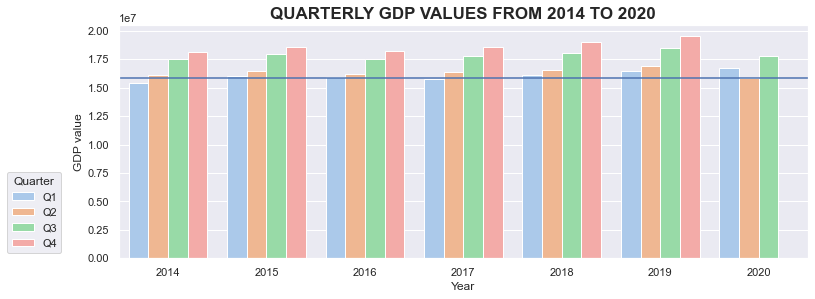

In [34]:
plt.figure(figsize = (11,4))
gdp_g = sns.barplot(x='Year', y="GDP value", hue='Quarter', palette='pastel',
                  data=melted_gdp)
gdp_g.legend(loc=3, title='Quarter', bbox_to_anchor=(-0.17,0))
gdp_g.axhline(15890000.00) # value of Q2 2020
gdp_g.set_title('QUARTERLY GDP VALUES FROM 2014 TO 2020', fontdict={'fontsize':17,'fontweight':'bold'})

* There is a slight decrease in the second quarter 2020 GDP value compared to the pre-COVID 2019 value.
* There's however no significant difference between second quarter GDP values before 2019 and Q2 values in 2020.
* All the years show an increase in GDP from Q1 to Q4 except 2020 in which there's a decrease in GDP from Q1 to Q2. This corresponds to the period of the first COVID-19 wave and national lockdown.

#### J - View the initial and revised bugdet for the year 2020 using a `barplot`

Text(0.5, 1.0, 'INITIAL AND REVISED BUDGETS DURING THE PANDEMIC')

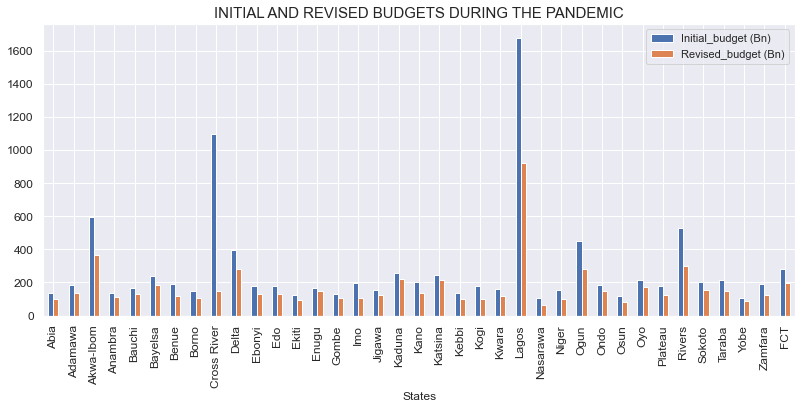

In [35]:
budget.plot('states', kind='bar', figsize=(12,5), fontsize=12, xlabel='States')
plt.title('INITIAL AND REVISED BUDGETS DURING THE PANDEMIC', fontsize=15)

* The state with the largest relative decrease in budget is Cross River followed by Lagos state. However, Cross River is not among the top 10 states most affected by COVID-19.

#### K - View monthly COVID-19 statistics

Text(0.5, 1.0, 'AGGREGATE CONFIRMED CASES PER MONTH')

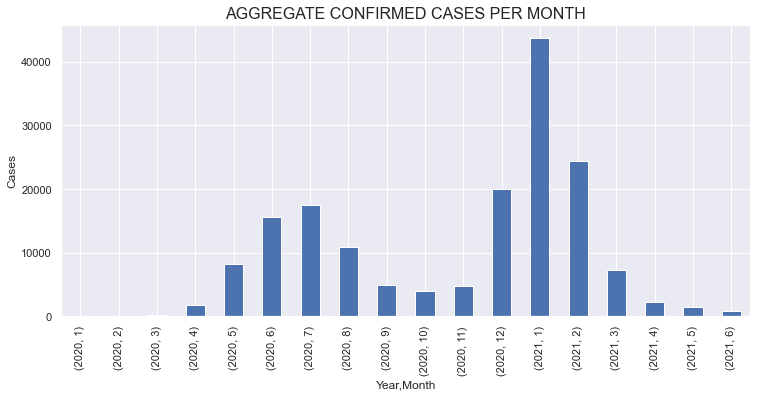

In [36]:
# Extract `Year` and `Month` data from the `Date` column.
confirmed_dly_nig['Year'] = confirmed_dly_nig['Date'].dt.year
confirmed_dly_nig['Month'] = confirmed_dly_nig['Date'].dt.month

# Group by year and month, then sum up no of monthly cases.
con_covid_mthly = confirmed_dly_nig.groupby(['Year', 'Month']).sum()

# Plot monthly data
con_covid_mthly.plot(y='Daily Cases', kind='bar', figsize=(11,5), ylabel='Cases', legend=False)
plt.title('AGGREGATE CONFIRMED CASES PER MONTH', fontsize=16)

* The highest number of monthly confirmed cases was seen in January followed by February

Text(0.5, 1.0, 'AGGREGATE RECOVERED CASES PER MONTH')

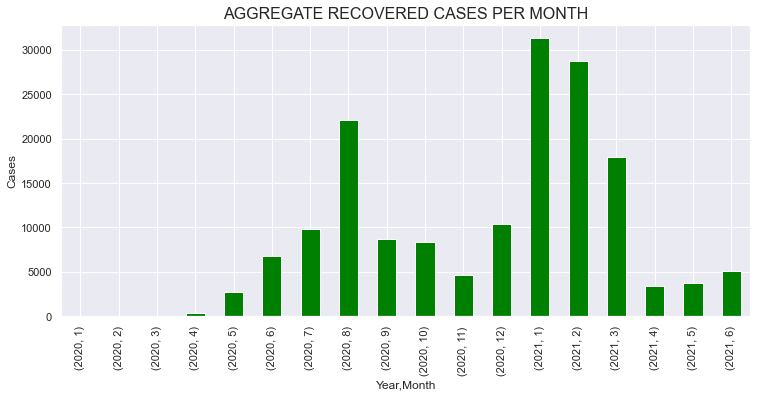

In [37]:
recovered_dly_nig['Year'] = recovered_dly_nig['Date'].dt.year
recovered_dly_nig['Month'] = recovered_dly_nig['Date'].dt.month
rec_covid_mthly = recovered_dly_nig.groupby(['Year', 'Month']).sum()

rec_covid_mthly.plot(y='Daily Cases', kind='bar', figsize=(11,5), ylabel='Cases', legend=False, color='green')
plt.title('AGGREGATE RECOVERED CASES PER MONTH', fontsize=16)

* The same pattern is seen as for confirmed cases but the difference in cases between the two months is much smaller.

Text(0.5, 1.0, 'AGGREGATE COVID DEATHS PER MONTH')

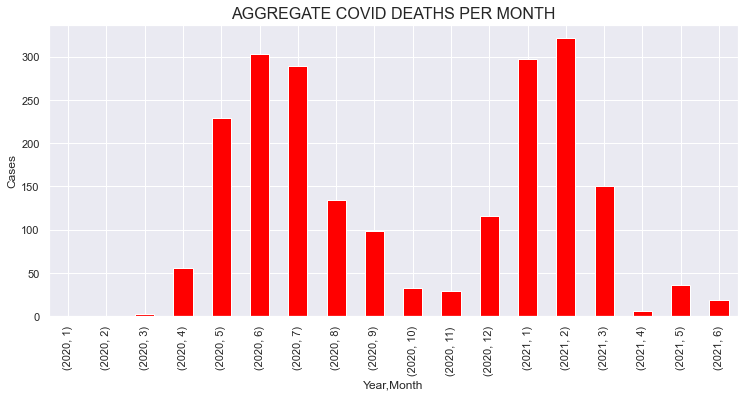

In [38]:
deaths_dly_nig['Year'] = deaths_dly_nig['Date'].dt.year
deaths_dly_nig['Month'] = deaths_dly_nig['Date'].dt.month
dths_covid_mthly = deaths_dly_nig.groupby(['Year', 'Month']).sum()

dths_covid_mthly.plot(y='Daily Cases', kind='bar', figsize=(11,5), ylabel='Cases', legend=False, color='red')
plt.title('AGGREGATE COVID DEATHS PER MONTH', fontsize=16)

* A two-phased spike in deaths is seen. However, the highest number of monthly deaths is seen in February, 2021 following the spike in number of confirmed and discharged cases that occurred in January.
* The month within which the second highest number of deaths was recorded is June, 2020.
* A similar profile of the number of deaths per month during both waves may be an indication of a reduced mortality rate during the second wave.